# Modeling Climate and Housing Data
## Question 1: Can we predict real estate purchase price based on climate indicators?
## 90-803 Machine Learning Foundations with Python (Spring 2024)
### Team 17: Yoko, Tessa, Hannah

We are attempting to predict home values (or purchase prices) based on climate indicators, so in this file we are exploring the following:
* Linear Regression
* Polynomial Regressions
* Feature selection
* Ridge regression
* Lasso regression
* RANSAC Linear regression for exclusing outliers

At the bottom of the file in the Appendix, please find these methods that were attempted but failed to make the model better:
* Encoding the Year and Month columns and scaling them

### Load Libraries

In [58]:
# importing relevant libraries
from datetime import datetime
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import geopandas as gpd
%matplotlib inline

# Importing metrics for model evaluation
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV 
from sklearn.feature_selection import SequentialFeatureSelector

# Importing class balance tools for handling imbalanced datasets
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from yellowbrick.target import ClassBalance

# Importing classifier models
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

### Read and Explore the Data

This file was previously cleaned, merged, and exported to a CSV in the Merging_Data.ipynb notebook. Below, the file is read and double checked.

In [59]:
# Read and look at data.
data = pd.read_csv("all_data.csv", index_col=0)
data.head()

,Date,Year,Month,RegionName,State,Bottom-Tier Average Home Value Estimate,Top-Tier Average Home Value Estimate,Value,Anomaly (1901-2000 base period),1901-2000 Mean,StateAbbrv,Initial Fees and Charges (%),Effective Rate (%),Term to Maturity,Loan Amount ($thou),Purchase Price ($thou),Loan-to-Price Ratio (%),Share of Total Market (%)
0,2000-01-31,2000,1,Los Angeles County,CA,122826.545216,400192.738911,52.3,4.5,47.8,CA,0.93,8.01,15,103.0,173.6,64.7,7.0
1,2000-01-31,2000,1,Los Angeles County,CA,122826.545216,400192.738911,52.3,4.5,47.8,CA,0.81,8.20,30,129.9,166.8,81.1,61.1
2,2000-01-31,2000,1,Cook County,IL,71689.188026,302264.545103,24.9,2.4,22.5,IL,0.93,8.01,15,103.0,173.6,64.7,7.0
3,2000-01-31,2000,1,Cook County,IL,71689.188026,302264.545103,24.9,2.4,22.5,IL,0.81,8.20,30,129.9,166.8,81.1,61.1
4,2000-01-31,2000,1,Harris County,TX,61195.175569,217850.462915,57.4,5.6,51.8,TX,0.93,8.01,15,103.0,173.6,64.7,7.0


We already have a 'Year' and 'Month' column. Since we don't want timeseries data, I am going to drop the 'Date' column. Furthermore, I am going to rename the 'Value' column to the more apt 'Average Temperature Value'. Finally, I am mapping the StateFPS code to the state name abbreviation so that we can merge with geospatial data.

In [60]:
# Drop date column
data.drop(columns=['Date'], inplace=True)

# Rename Value column
data.rename(columns={'Value': 'Average Temperature Value'}, inplace=True)

# Map the state abbreviation tothe stateFPS in a new column
data['StateFPS'] = data['StateAbbrv'].map(state_to_fips)

### Read in Geo-data
We want to relate this data to where the counties exist in geospatial relation to one another, especially because Latitude and Longitude may be important features. So we are going to read the county shapefiles for the contiguous United States, and merge it into our dataset.

In [61]:
# Loading the shapefile in order to visualize clean data on the US map
us_counties = gpd.read_file('tl_2022_us_county/tl_2022_us_county.shp')
print(us_counties.columns)
us_counties.head()

Index(['STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD',
       'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT', 'ALAND',
       'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry'],
      dtype='object')


,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,31,039,00835841,31039,Cuming,Cuming County,06,H1,G4020,None,None,None,A,1477644346,10691216,+41.9158651,-096.7885168,"POLYGON ((-96.55515 41.91587, -96.55515 41.914..."
1,53,069,01513275,53069,Wahkiakum,Wahkiakum County,06,H1,G4020,None,None,None,A,680980770,61564427,+46.2946377,-123.4244583,"POLYGON ((-123.72755 46.26449, -123.72755 46.2..."
2,35,011,00933054,35011,De Baca,De Baca County,06,H1,G4020,None,None,None,A,6016818946,29090018,+34.3592729,-104.3686961,"POLYGON ((-104.89337 34.08894, -104.89337 34.0..."
3,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,None,None,None,A,2169272978,22847034,+40.7835474,-096.6886584,"POLYGON ((-96.68493 40.52330, -96.69219 40.523..."
4,31,129,00835886,31129,Nuckolls,Nuckolls County,06,H1,G4020,None,None,None,A,1489645185,1718484,+40.1764918,-098.0468422,"POLYGON ((-98.27370 40.11840, -98.27374 40.122..."


In [62]:
# Merge the geospatial United States map with the data
data = us_counties.merge(data, left_on=['NAMELSAD', 'STATEFP'], right_on=['RegionName', 'StateFPS'])
print(data.columns)
data.head()

Index(['STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD',
       'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT', 'ALAND',
       'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry', 'Year', 'Month',
       'RegionName', 'State', 'Bottom-Tier Average Home Value Estimate',
       'Top-Tier Average Home Value Estimate', 'Average Temperature Value',
       'Anomaly (1901-2000 base period)', '1901-2000 Mean', 'StateAbbrv',
       'Initial Fees and Charges (%)', 'Effective Rate (%)',
       'Term to Maturity', 'Loan Amount ($thou)', 'Purchase Price ($thou)',
       'Loan-to-Price Ratio (%)', 'Share of Total Market (%)', 'StateFPS'],
      dtype='object')


,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,...,1901-2000 Mean,StateAbbrv,Initial Fees and Charges (%),Effective Rate (%),Term to Maturity,Loan Amount ($thou),Purchase Price ($thou),Loan-to-Price Ratio (%),Share of Total Market (%),StateFPS
0,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,None,...,22.2,NE,0.93,8.01,15,103.0,173.6,64.7,7.0,31
1,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,None,...,22.2,NE,0.81,8.20,30,129.9,166.8,81.1,61.1,31
2,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,None,...,27.3,NE,0.91,8.18,15,100.5,172.8,63.1,7.2,31
3,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,None,...,27.3,NE,0.78,8.39,30,127.8,163.7,81.2,58.6,31
4,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,None,...,38.0,NE,0.87,8.24,15,101.2,176.9,62.7,7.2,31


After merging, let's double check that we do not have null values that we do not expect. Note: I do expect some _irrelevant_ columns to contain Nulls because they are null in the shapefiles; but we are going to drop those columns.

In [63]:
# What does our dataframe look like right now?
data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 579894 entries, 0 to 579893
Data columns (total 36 columns):
 #   Column                                   Non-Null Count   Dtype   
---  ------                                   --------------   -----   
 0   STATEFP                                  579894 non-null  object  
 1   COUNTYFP                                 579894 non-null  object  
 2   COUNTYNS                                 579894 non-null  object  
 3   GEOID                                    579894 non-null  object  
 4   NAME                                     579894 non-null  object  
 5   NAMELSAD                                 579894 non-null  object  
 6   LSAD                                     579894 non-null  object  
 7   CLASSFP                                  579894 non-null  object  
 8   MTFCC                                    579894 non-null  object  
 9   CSAFP                                    0 non-null       object  
 10  CBSAFP      

**Note:** In the appendix, we explore encoding and scaling the Year and Month columns. This renders R2 values that are really bad (on the order of E+20 and higher). So, we are not including them to be scaled here, nor did we previously encode them.

In [64]:
# Extract the columns that we want to scale
columns_to_scale = data.drop(columns=['Year', 'Month', 'RegionName', 'State', 'StateFPS', 'StateAbbrv', \
                       'STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD',\
                       'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT','geometry']).columns

# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler to the specified columns
scaler.fit(data[columns_to_scale])

# Transform the data using the fitted scaler and convert it back to a DataFrame
scaled_data = scaler.transform(data[columns_to_scale])
data[columns_to_scale] = pd.DataFrame(scaled_data, columns=columns_to_scale, index=data.index)

# Display the first few rows of the scaled columns to verify the values look scaled at first glance
data[columns_to_scale].head()

,ALAND,AWATER,INTPTLAT,INTPTLON,Bottom-Tier Average Home Value Estimate,Top-Tier Average Home Value Estimate,Average Temperature Value,Anomaly (1901-2000 base period),1901-2000 Mean,Initial Fees and Charges (%),Effective Rate (%),Term to Maturity,Loan Amount ($thou),Purchase Price ($thou),Loan-to-Price Ratio (%),Share of Total Market (%)
0,-0.04576,-0.288067,0.605918,-0.559929,-0.256856,-0.391808,-1.569987,1.539034,-1.878226,0.105420,2.478430,-1.0,-2.007124,-2.350378,-0.913730,-1.040546
1,-0.04576,-0.288067,0.605918,-0.559929,-0.256856,-0.391808,-1.569987,1.539034,-1.878226,-0.223290,2.632607,1.0,-1.279980,-2.535091,1.004406,0.813359
2,-0.04576,-0.288067,0.605918,-0.559929,-0.254749,-0.390204,-1.108955,2.365461,-1.579980,0.050635,2.616377,-1.0,-2.074703,-2.372109,-1.100866,-1.033692
3,-0.04576,-0.288067,0.605918,-0.559929,-0.254749,-0.390204,-1.108955,2.365461,-1.579980,-0.305468,2.786784,1.0,-1.336746,-2.619298,1.016102,0.727689
4,-0.04576,-0.288067,0.605918,-0.559929,-0.252694,-0.388732,-0.653759,1.509519,-0.954246,-0.058935,2.665065,-1.0,-2.055781,-2.260738,-1.147649,-1.033692


In [65]:
# Let's also look at the dataframe as a whole to check that the rest of the data still looks kosher
data.head()

Year  Month          RegionName State  \
0  2000      1  Los Angeles County    CA   
1  2000      1  Los Angeles County    CA   
2  2000      1         Cook County    IL   
3  2000      1         Cook County    IL   
4  2000      1       Harris County    TX   

   MTFCC CSAFP  ... 1901-2000 Mean StateAbbrv Initial Fees and Charges (%)  \
0  G4020  None  ...      -1.878226         NE                     0.105420   
1  G4020  None  ...      -1.878226         NE                    -0.223290   
2  G4020  None  ...      -1.579980         NE                     0.050635   
3  G4020  None  ...      -1.579980         NE                    -0.305468   
4  G4020  None  ...      -0.954246         NE                    -0.058935   

   Effective Rate (%)  Term to Maturity  Loan Amount ($thou)  \
0            2.478430              -1.0            -2.007124   
1            2.632607               1.0            -1.279980   
2            2.616377              -1.0            -2.074703   
3            2.786784               1.0            -1.336746   
4            2.665065              -1.0            -2.055781   

   Purchase Price ($thou) Loan-to-Price Ratio (%)  Share of Total Market (%)  \
0               -2.350378               -0.913730                  -1.040546   
1               -2.535091                1.004406                   0.813359   
2               -2.372109               -1.100866                  -1.033692   
3               -2.619298                1.016102                   0.727689   
4               -2.260738               -1.147649                  -1.033692   

   CSAFP  CBSAFP  METDIVFP  FUNCSTAT        ALAND      AWATER     INTPTLAT  \
0   None    None      None         A  10515988166  1785003207  +34.1963983   
1   None    None      None         A  10515988166  1785003207  +34.1963983   
2   None    None      None         A   2447342616  1786339408  +41.8942937   
3   None    None      None         A   2447342616  1786339408  +41.8942937   
4   None    None      None         A   4421145870   182187806  +29.8572730   

       INTPTLON                                           geometry  
0  -118.2618616  MULTIPOLYGON (((-118.67820 33.03973, -118.6756...  
1  -118.2618616  MULTIPOLYGON (((-118.67820 33.03973, -118.6756...  
2  -087.6454546  POLYGON ((-87.52500 41.64464, -87.52505 41.639...  
3  -087.6454546  POLYGON ((-87.52500 41.64464, -87.52505 41.639...  
4  -095.3930371  POLYGON ((-94.97885 29.67673, -94.97918 29.676...  

[5 rows x 36 columns]

### Split the data
Because this data is origianlly time series, we have broken the year and month into their own columns and dropped the date. Next, we are going to use the latest year as the "test" dataset and all previous years as training.

In [66]:
# Test set is all of the last year of the dataset
test = data[data['Year'] == 2019].copy()

# Train set is all of the other years
train = data[data['Year'] != 2019].copy()

# Target is purchase price, training is done on all over columns EXCEPT irrelevant geospatial columns (which are still needed for plotting maps)
y_test = test['Purchase Price ($thou)'].copy()
y_train = train['Purchase Price ($thou)'].copy()
X_train = train.drop(columns=['RegionName', 'State', 'StateAbbrv', 'Purchase Price ($thou)', \
                       'STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD',\
                       'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT','geometry']).copy()
X_test = test.drop(columns=['RegionName', 'State', 'StateAbbrv', 'Purchase Price ($thou)', \
                       'STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD',\
                       'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT','geometry']).copy()

# Look at the data for one of these -- looks OK
X_test.head()

,ALAND,AWATER,INTPTLAT,INTPTLON,Year,Month,Bottom-Tier Average Home Value Estimate,Top-Tier Average Home Value Estimate,Average Temperature Value,Anomaly (1901-2000 base period),1901-2000 Mean,Initial Fees and Charges (%),Effective Rate (%),Term to Maturity,Loan Amount ($thou),Loan-to-Price Ratio (%),Share of Total Market (%)
456,-0.04576,-0.288067,0.605918,-0.559929,2019,1,0.625861,0.142892,-1.791749,0.417454,-1.878226,1.475045,-0.426591,-1.0,0.579781,-0.609636,-1.074814
457,-0.04576,-0.288067,0.605918,-0.559929,2019,1,0.625861,0.142892,-1.791749,0.417454,-1.878226,0.790232,-0.045205,1.0,1.985413,1.016102,1.293113
458,-0.04576,-0.288067,0.605918,-0.559929,2019,2,0.634614,0.147498,-2.211930,-3.212921,-1.579980,1.036765,-0.613226,-1.0,0.663578,-0.551156,-1.050826
459,-0.04576,-0.288067,0.605918,-0.559929,2019,2,0.634614,0.147498,-2.211930,-3.212921,-1.579980,0.653270,-0.150695,1.0,1.725912,0.957622,1.159467
460,-0.04576,-0.288067,0.605918,-0.559929,2019,3,0.647434,0.153817,-1.272359,-1.619098,-0.954246,0.516307,-0.783632,-1.0,0.925783,-0.878642,-1.043973


### Model 1: Linear Regression
The first no-brainer model to try is a first-order linear regression with all features included. Below are some functions to facilitate running this model with different features selected.

In [74]:
# your code here
def run_linear_model(X_train, y_train, X_test, y_test):
    """
    Constructs a LinearRegression object, fits the train data, and predicts the y_train and y_test data
    and prints the MSE and R2 values.
    X_train, y_train, X_test, y_test: training and testing data
    returns: r_squared_train_linear, mean_squared_error_train_linear, r_squared_test_linear, mean_squared_error_test_linear, l_model
    """
    # Construct the model, fit the data, and predict
    l_model = LinearRegression()
    l_model.fit(X_train, y_train)
    y_pred_train = l_model.predict(X_train)
    y_pred_test = l_model.predict(X_test)

    # Get R2 values
    r_squared_train_linear = r2_score(y_train, y_pred_train)
    r_squared_test_linear = r2_score(y_test, y_pred_test)

    # Get MSE values
    mean_squared_error_train_linear = mean_squared_error(y_train, y_pred_train)
    mean_squared_error_test_linear = mean_squared_error(y_test, y_pred_test)

    # Printing results for training
    print('r_squared_train:', round(r_squared_train_linear, 5))
    print('mean_squared_error_train:', round(mean_squared_error_train_linear, 5))

    # Printing results for testing
    print('r_squared_test:',round(r_squared_test_linear, 5))
    print('mean_squared_error_test:',round(mean_squared_error_test_linear, 5))
    return r_squared_train_linear, mean_squared_error_train_linear, r_squared_test_linear, mean_squared_error_test_linear, l_model

# Run the model with all of the features. Saving results to an object so that they don't needlessly print.
results = run_linear_model(X_train, y_train, X_test, y_test)

r_squared_train: 0.9643
mean_squared_error_train: 0.03438
r_squared_test: 0.54786
mean_squared_error_test: 0.033


The training data did incredibly well where the test data did just OK. The MSE values for both are decently low but there is a mismatch with R2 values. This seems suspicious.

I am going to check which features are most important below.

## Feature Selection

In [68]:
# Run SequentialFeatureSelector using up to 12 features. (That number is arbitrarily slightly less than the number of features I have,
# because I already know that this is just a jumping off point for further exploration of the 'best' features.)
for i in range(1, 12):
    # Choosing 'forward' because 'backward' actually failed to fun in reasonable time, and it shouldn't matter
    sfs = SequentialFeatureSelector(estimator=LinearRegression(),
                                    n_features_to_select=i,
                                    direction = 'forward',
                                    scoring = 'r2')
    
    # Fit the training data
    sfs = sfs.fit(X_train, y_train)

    # Convert to and print a readable list
    feature_names = np.array(X_train.columns)
    selected_feature_names = feature_names[sfs.get_support()].tolist()
    print("\n", i, " selected feature(s):", selected_feature_names)

    # Run the model with those features so that I can see for myself what the R2 and MSE are
    run_linear_model(X_train[selected_feature_names], y_train, X_test[selected_feature_names], y_test)


Selected features: ['Year']
r_squared_train: 0.56
mean_squared_error_train: 0.424
r_squared_test: -2.24
mean_squared_error_test: 0.236

Selected features: ['Year', 'Loan Amount ($thou)']
r_squared_train: 0.628
mean_squared_error_train: 0.359
r_squared_test: -2.375
mean_squared_error_test: 0.246

Selected features: ['Year', 'Loan Amount ($thou)', 'Loan-to-Price Ratio (%)']
r_squared_train: 0.938
mean_squared_error_train: 0.06
r_squared_test: 0.334
mean_squared_error_test: 0.049

Selected features: ['Year', 'Loan Amount ($thou)', 'Loan-to-Price Ratio (%)', 'Share of Total Market (%)']
r_squared_train: 0.958
mean_squared_error_train: 0.04
r_squared_test: 0.672
mean_squared_error_test: 0.024

Selected features: ['Year', 'Initial Fees and Charges (%)', 'Loan Amount ($thou)', 'Loan-to-Price Ratio (%)', 'Share of Total Market (%)']
r_squared_train: 0.963
mean_squared_error_train: 0.036
r_squared_test: 0.401
mean_squared_error_test: 0.044

Selected features: ['Year', 'Initial Fees and Charges

The "best" R2 above is about 0.672, which is not terrible. However, I notice that the selected features are Year and 3 related to the housing market itself. It makes sense that it does reasonably well using those features. Below, I am going to rerun the model with those features, and use that as a starting point to add features that I specifically want to test (ie, does dropping this feature help or hurt the model)?

In [75]:
# Rerun with the features that SFS said are the best
results = run_linear_model(X_train[['Year', 'Loan Amount ($thou)', 'Loan-to-Price Ratio (%)', 'Share of Total Market (%)']], 
                        y_train, X_test[['Year', 'Loan Amount ($thou)', 'Loan-to-Price Ratio (%)', 'Share of Total Market (%)']], y_test)

r_squared_train: 0.95845
mean_squared_error_train: 0.04001
r_squared_test: 0.67162
mean_squared_error_test: 0.02397


In [76]:
# Next, I want to know if we do better or worse when we add temperature/climate data
results = run_linear_model(X_train[['Year', 'Loan Amount ($thou)', 'Loan-to-Price Ratio (%)', 'Share of Total Market (%)',
                                    'Average Temperature Value', 'Anomaly (1901-2000 base period)', '1901-2000 Mean']], 
                           y_train, 
                           X_test[['Year', 'Loan Amount ($thou)', 'Loan-to-Price Ratio (%)', 'Share of Total Market (%)',
                                   'Average Temperature Value', 'Anomaly (1901-2000 base period)', '1901-2000 Mean']], 
                           y_test)

r_squared_train: 0.95864
mean_squared_error_train: 0.03983
r_squared_test: 0.64475
mean_squared_error_test: 0.02593


Just adding climate data alone doesn't help the model.

In [77]:
# Swap '1901-2000 Mean' for 'Effective Rate (%)' just to see what happens
results = run_linear_model(X_train[['Year', 'Average Temperature Value', 'Anomaly (1901-2000 base period)', 'Effective Rate (%)', 
                                    'Loan Amount ($thou)', 'Loan-to-Price Ratio (%)','Share of Total Market (%)']], 
                           y_train, 
                           X_test[['Year', 'Average Temperature Value', 'Anomaly (1901-2000 base period)', 'Effective Rate (%)', 
                                   'Loan Amount ($thou)', 'Loan-to-Price Ratio (%)', 'Share of Total Market (%)']], 
                           y_test)

r_squared_train: 0.95985
mean_squared_error_train: 0.03867
r_squared_test: 0.78879
mean_squared_error_test: 0.01541


#### This significantly improved the model!
(These might be our preferred features.)

Let's keep exploring to be sure.

In [78]:
# Add 'Initial Fees and Charges'
results = run_linear_model(X_train[['Year', 'Average Temperature Value', 'Anomaly (1901-2000 base period)', 'Effective Rate (%)', 
                                    'Loan Amount ($thou)', 'Loan-to-Price Ratio (%)','Share of Total Market (%)', 'Initial Fees and Charges (%)']], 
                           y_train, 
                           X_test[['Year', 'Average Temperature Value', 'Anomaly (1901-2000 base period)', 'Effective Rate (%)', 
                                   'Loan Amount ($thou)', 'Loan-to-Price Ratio (%)', 'Share of Total Market (%)', 'Initial Fees and Charges (%)']], 
                           y_test)

r_squared_train: 0.96405
mean_squared_error_train: 0.03462
r_squared_test: 0.59049
mean_squared_error_test: 0.02989


In [80]:
# Going back to our previous best, let's see what happens when we remove 'Average Temperature Value
results = run_linear_model(X_train[['Year', 'Anomaly (1901-2000 base period)', 'Effective Rate (%)', 
                                    'Loan Amount ($thou)', 'Loan-to-Price Ratio (%)','Share of Total Market (%)']], 
                           y_train, 
                           X_test[['Year', 'Anomaly (1901-2000 base period)', 'Effective Rate (%)', 
                                   'Loan Amount ($thou)', 'Loan-to-Price Ratio (%)', 'Share of Total Market (%)']], 
                           y_test)

r_squared_train: 0.95968
mean_squared_error_train: 0.03883
r_squared_test: 0.79725
mean_squared_error_test: 0.0148


In [35]:
# Going back to our previous best, let's see what happens when we remove 'Average Temperature Value
results = run_linear_model(X_train[['Year', 'Effective Rate (%)', 'Loan Amount ($thou)', 'Loan-to-Price Ratio (%)','Share of Total Market (%)']], 
                           y_train, 
                           X_test[['Year', 'Effective Rate (%)', 'Loan Amount ($thou)', 'Loan-to-Price Ratio (%)', 'Share of Total Market (%)']], 
                           y_test)

r_squared_train: 0.95967
mean_squared_error_train: 0.03884
r_squared_test: 0.79621
mean_squared_error_test: 0.01487


Removing 'Average Temperature Value' helped the model -- we went from R2 of 0.789 to 0.797. HOWEVER, _also_ removing 'Anomaly (1901-2000 base period)' _lowered_ the R2 value from 0.797 to 0.796. As a sanity check, let me see if we just run it with 'Average Temperature Value' and no 'Anomaly (1901-2000 base period)' -- I suspect it will be worse than 0.789.

In [36]:
# Add 'Initial Fees and Charges'
results = run_linear_model(X_train[['Year', 'Average Temperature Value', 'Effective Rate (%)', 'Loan Amount ($thou)', 
                                    'Loan-to-Price Ratio (%)','Share of Total Market (%)', 'Initial Fees and Charges (%)']], 
                           y_train, 
                           X_test[['Year', 'Average Temperature Value', 'Effective Rate (%)', 'Loan Amount ($thou)', 
                                   'Loan-to-Price Ratio (%)', 'Share of Total Market (%)', 'Initial Fees and Charges (%)']], 
                           y_test)

r_squared_train: 0.96399
mean_squared_error_train: 0.03468
r_squared_test: 0.58601
mean_squared_error_test: 0.03021


As suspected, 'Average Temperature Value' isn't a good feature (at least, not alone). But 'Anomaly (1901-2000 base period)' actually does improve the model, ever so slightly!

#### These are the features I am going to proceed with.

In [85]:
# Pull the finalized selected features into their own dataframes. target arrays get to stay the same (y_test and y_train)
X_train_selected = X_train[['Year', 'Anomaly (1901-2000 base period)', 'Effective Rate (%)', 
                            'Loan Amount ($thou)', 'Loan-to-Price Ratio (%)','Share of Total Market (%)']]
X_test_selected = X_test[['Year', 'Anomaly (1901-2000 base period)', 'Effective Rate (%)', 
                          'Loan Amount ($thou)', 'Loan-to-Price Ratio (%)','Share of Total Market (%)']]

# Rerun the model once more to verify I still see what I thought I would see ...
r_squared_train_linear, mean_squared_error_train_linear, r_squared_test_linear, mean_squared_error_test_linear, l_model =\
    run_linear_model(X_train_selected, y_train, X_test_selected, y_test)

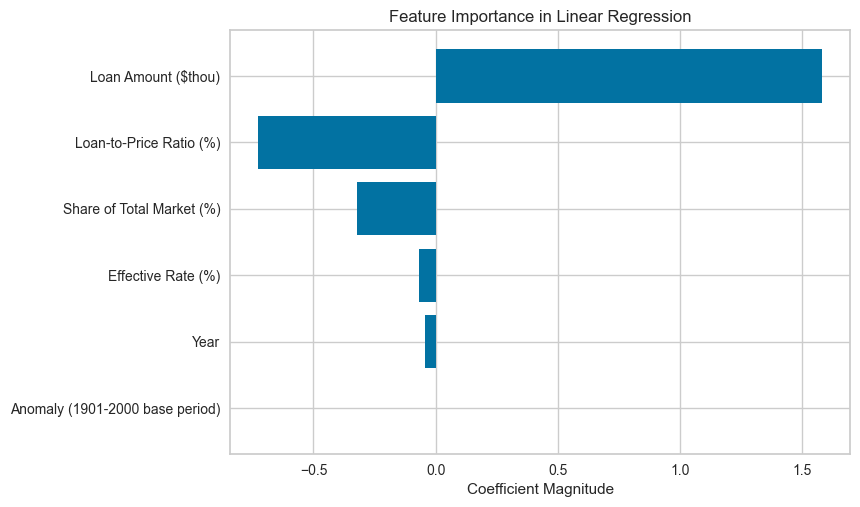

,Feature,Coefficient
1,Anomaly (1901-2000 base period),0.002613
0,Year,-0.044778
2,Effective Rate (%),-0.068928
5,Share of Total Market (%),-0.322493
4,Loan-to-Price Ratio (%),-0.726020
3,Loan Amount ($thou),1.582045


In [88]:
# Pull out the feature importances (the coeficients)
feat_importance = pd.DataFrame({'Feature': X_train_selected.columns, 'Coefficient': l_model.coef_})
feat_importance = feat_importance.sort_values(by='Coefficient', key=abs, ascending=True)

# Creating the bar plot
plt.barh(feat_importance['Feature'], feat_importance['Coefficient'])
plt.xlabel('Coefficient Magnitude')
plt.title('Feature Importance in Linear Regression')
plt.show()

feat_importance

The feature importance of **Anomaly (1901-2000 base period)** is extremely low -- it doesn't even show up on the plot -- but it _did_ improve our R2 value for our test data. I think it is worth including.

**Main takeaways:** The linear model is quite good. The MSE is relatively low and the R2 is quite high, and tuned to a decent 'height' of 0.797 via feature selection. The temperature anomaly in each county, compared to the previous century, _is an included feature_ which improves the performance of the model, even if only a little bit. This means that **it is ultimately possible to predict house purchase prices, and temperature anomaly is a contributing feature.**

# Polynomial Features

Next, let me try fitting some polynomials. I am going to use our selected data and see what happens with the R2 values as we go through.

In [22]:
y_poly_preds = []
for x in range(1,4):
    # Create the polynomial features object
    X_poly = PolynomialFeatures(degree=x)

    # Fit and transform the data
    X_polynomial_train = X_poly.fit_transform(X_train_selected)
    X_polynomial_test = X_poly.fit_transform(X_test_selected)

    # Create and fit the model
    model_poly = LinearRegression()
    model_poly.fit(X_polynomial_train, y_train)

    # Get predictions
    y_pred_poly_test = model_poly.predict(X_polynomial_test)
    y_pred_poly_train = model_poly.predict(X_polynomial_train)
    y_poly_preds.append(y_pred_poly_test)

    # Get R2 values
    r_squared_train_poly = model_poly.score(X_polynomial_train, y_train)
    r_squared_test_poly = model_poly.score(X_polynomial_test, y_test)

    # Get MSE values
    mean_squared_error_train_poly = mean_squared_error(y_train, y_pred_poly_train)
    mean_squared_error_test_poly = mean_squared_error(y_test, y_pred_poly_test)

# Printing results for testing
print('r_squared_test:',round(r_squared_test_linear, 3))
print('mean_squared_error_test:',round(mean_squared_error_test_linear, 3))


r_squared_train: 0.879
mean_squared_error_train: 158.229
r_squared_test: 0.34
mean_squared_error_test: 65.232


My computer fails to run anything beyond the 3rd degree -- but it is doubtful that it would help. It clearly begins to overfit to the training data when we increase the polynomial beyond linear.

### Model 2: Ridge Regression

In [28]:
ridge = Ridge()
ridge.fit(X_train, y_train)

y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)

mse_train_ridge = mean_squared_error(y_train, y_pred_train)
mse_test_ridge = mean_squared_error(y_test, y_pred_test)
r2_train_ridge = ridge.score(X_train, y_train)
r2_test_ridge = ridge.score(X_test, y_test)
print("MSE train:", mse_train_ridge)
print("MSE test:", mse_test_ridge)
print("Train R2:", r2_train_ridge) 
print("Test R2:", r2_test_ridge) 


MSE train: 0.03438199295083276
MSE test: 0.03299819396350691
Train R2: 0.9642965121305692
Test R2: 0.5478570878737481


In [29]:
alphas = [0.001,0.01,0.1,1.0,10,100,1000,10000,100000,1000000]

# Printing results for training
print('r_squared_train:', round(r_squared_train_linear, 3))
print('mean_squared_error_train:', round(mean_squared_error_train_linear, 3))

for a in alphas:
    ridge = Ridge(alpha=a)
    ridge.fit(X_train, y_train)

    y_pred_train = ridge.predict(X_train)
    y_pred_test = ridge.predict(X_test)

    mse_train_ridge = mean_squared_error(y_train, y_pred_train)
    mse_test_ridge = mean_squared_error(y_test, y_pred_test)
    r2_train_ridge = ridge.score(X_train, y_train)
    r2_test_ridge = ridge.score(X_test, y_test)
    print("Alpha: ", a)
    print("MSE train:", mse_train_ridge)
    print("MSE test:", mse_test_ridge)
    print("Train R2:", r2_train_ridge) 
    print("Test R2:", r2_test_ridge) 
    print("")
    
    ridge_coeffs.append(ridge.coef_)
    mse_train_ridges.append(mse_train_ridge)
    mse_test_ridges.append(mse_test_ridge)
    r2_train_ridges.append(r2_train_ridge)
    r2_test_ridges.append(r2_test_ridge)

Alpha:  0.001
MSE train: 0.03438183893166476
MSE test: 0.03299818249236433
Train R2: 0.964296672069567
Test R2: 0.5478572450519203

Alpha:  0.01
MSE train: 0.034381841958553615
MSE test: 0.032998302386232754
Train R2: 0.9642966689263377
Test R2: 0.5478556022601095

Alpha:  0.1
MSE train: 0.03438190271048622
MSE test: 0.032998762910982624
Train R2: 0.9642966058393638
Test R2: 0.5478492921268414

Alpha:  1.0
MSE train: 0.03438199295083276
MSE test: 0.03299819396350691
Train R2: 0.9642965121305692
Test R2: 0.5478570878737481

Alpha:  10
MSE train: 0.03438202025154538
MSE test: 0.03298822963531767
Train R2: 0.9642964837805353
Test R2: 0.5479936195993889

Alpha:  100
MSE train: 0.034382892052639544
MSE test: 0.032888038655972576
Train R2: 0.9642955784711825
Test R2: 0.5493664414338193

Alpha:  1000
MSE train: 0.034466256236673945
MSE test: 0.03190840080283636
Train R2: 0.9642090101289205
Test R2: 0.5627894885325777

Alpha:  10000
MSE train: 0.040555669988296385
MSE test: 0.02521924642251009

In [30]:
min_mse_train_ridge = np.min(mse_train_ridges)
print("Min MSE train: ", min_mse_train_ridge)
min_mse_train_ridge_index = np.argmin(mse_train_ridges)
print("Index of Min MSE train: ", min_mse_train_ridge_index)
best_alpha = alphas[min_mse_train_ridge_index]
print("Best alpha: ", best_alpha)
print("R2 test: ", r2_test_ridges[min_mse_train_ridge_index])

Min MSE train:  0.03438183893166476
Index of Min MSE train:  0
Best alpha:  0.001
R2 test:  0.5478572450519203


Clearly, removing features that are related to TIME or related to HOUSING breaks the model -- which kind of indicates that attempting to predict housing purchase prices based solely on geographical and climate data is WORSE than random!

**This likely means we need to go back to the drawing board.** 

To be certain, I will try a higher degree polynomial below.

## Polynomial Features
First, I am resetting the test and train datasets back to have the most informatio possible.

In [31]:
alphas = [0.001,0.01,0.1,1.0,10,100,1000,10000,100000,1000000]

ridge_coeffs = []
mse_train_ridges = []
mse_test_ridges = []
r2_train_ridges = []
r2_test_ridges = []

for a in alphas:
    ridge = Ridge(alpha=a)
    ridge.fit(X_train_selected, y_train)

    y_pred_train = ridge.predict(X_train_selected)
    y_pred_test = ridge.predict(X_test_selected)

    mse_train_ridge = mean_squared_error(y_train, y_pred_train)
    mse_test_ridge = mean_squared_error(y_test, y_pred_test)
    r2_train_ridge = ridge.score(X_train_selected, y_train)
    r2_test_ridge = ridge.score(X_test_selected, y_test)
    print("Alpha: ", a)
    print("MSE train:", mse_train_ridge)
    print("MSE test:", mse_test_ridge)
    print("Train R2:", r2_train_ridge) 
    print("Test R2:", r2_test_ridge) 
    print("")
    
    ridge_coeffs.append(ridge.coef_)
    mse_train_ridges.append(mse_train_ridge)
    mse_test_ridges.append(mse_test_ridge)
    r2_train_ridges.append(r2_train_ridge)
    r2_test_ridges.append(r2_test_ridge)

Alpha:  0.001
MSE train: 0.03866726336665324
MSE test: 0.015414425189510379
Train R2: 0.9598465344772298
Test R2: 0.7887907713481183

Alpha:  0.01
MSE train: 0.03866726336666159
MSE test: 0.015414419511285369
Train R2: 0.9598465344772211
Test R2: 0.7887908491514427

Alpha:  0.1
MSE train: 0.03866726336751277
MSE test: 0.015414362729622997
Train R2: 0.9598465344763373
Test R2: 0.7887916271766343

Alpha:  1.0
MSE train: 0.03866726345265075
MSE test: 0.015413794970680642
Train R2: 0.9598465343879269
Test R2: 0.7887994066381971

Alpha:  10
MSE train: 0.038667271963905944
MSE test: 0.015408123147805737
Train R2: 0.959846525549536
Test R2: 0.7888771222402862

Alpha:  100
MSE train: 0.03866812054971888
MSE test: 0.01535197990366423
Train R2: 0.9598456443477591
Test R2: 0.7896463997931858

Alpha:  1000
MSE train: 0.03875050336213722
MSE test: 0.014846415332732857
Train R2: 0.9597600950967883
Test R2: 0.7965736709529823

Alpha:  10000
MSE train: 0.04502741125989776
MSE test: 0.01407171620101822

In [33]:
# y_poly_preds = []
# for x in range(1,5):
#     X_poly = PolynomialFeatures(degree=x)
#     X_polynomial_train = X_poly.fit_transform(X_train)
#     X_polynomial_test = X_poly.fit_transform(X_test)
#     model_poly = LinearRegression()
#     model_poly.fit(X_polynomial_train, y_train)

#     y_pred_poly_test = model_poly.predict(X_polynomial_test)
#     y_pred_poly_train = model_poly.predict(X_polynomial_train)
#     y_poly_preds.append(y_pred_poly_test)

#     r_squared_train_poly = model_poly.score(X_polynomial_train, y_train)
#     r_squared_test_poly = model_poly.score(X_polynomial_test, y_test)

#     mean_squared_error_train_poly = mean_squared_error(y_train, y_pred_poly_train)
#     mean_squared_error_test_poly = mean_squared_error(y_test, y_pred_poly_test)

#     # Printing results for training
#     print('----------------------------')
#     print("Degree: ", x)
#     print('r_squared_train:', r_squared_train_poly)
#     print('mean_squared_error_train:', mean_squared_error_train_poly)

#     # Printing results for testing
#     print('r_squared_test:',r_squared_test_poly)
#     print('mean_squared_error_test:',mean_squared_error_test_poly)
#     print('----------------------------')
#     print("")

Min MSE train:  0.03866726336665324
Index of Min MSE train:  0
Best alpha:  0.001
R2 test:  0.7887907713481183


Below, I have pasted an image of the output produced by this code. Above, the code is commented out, because it fails due to memory allocation. This makes sense because the dataset is currently 2.7 million rows, and attempting to fit higher-order polynomials simply requries more memory than can be allocated by my computer. The result:
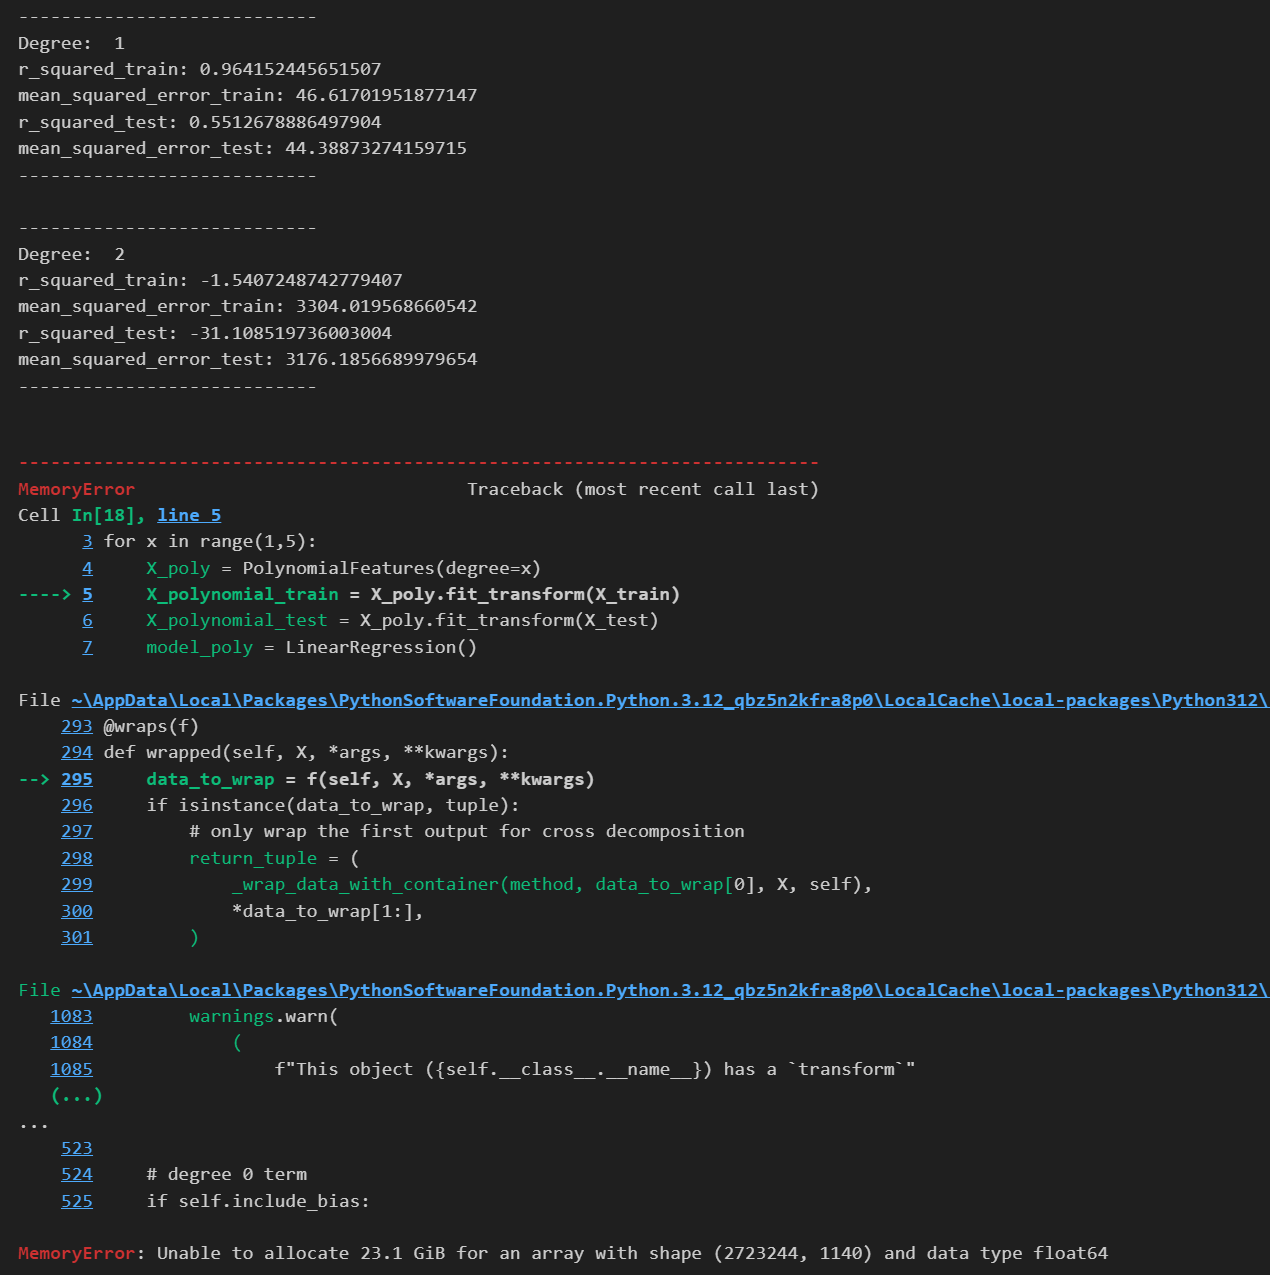

This is already pretty good and very similar to the regular Linear Regression.
## Lasso

In [32]:
lasso = Lasso()
lasso.fit(X_train, y_train)

y_pred_train = lasso.predict(X_train)
y_pred_test = lasso.predict(X_test)

mse_train_lasso = mean_squared_error(y_train, y_pred_train)
mse_test_lasso = mean_squared_error(y_test, y_pred_test)
r2_train_lasso = lasso.score(X_train, y_train)
r2_test_lasso = lasso.score(X_test, y_test)
print("MSE train:", mse_train_lasso)
print("MSE test:", mse_test_lasso)
print("Train R2:", r2_train_lasso) 
print("Test R2:", r2_test_lasso) 


MSE train: 0.4596349549755995
MSE test: 0.5774521041740859
Train R2: 0.5226986677937695
Test R2: -6.912277753244508


In [34]:
alphas = [0.001,0.01,0.1,1.0,10,100,1000,10000,100000,1000000]

lasso_coeffs = []
mse_train_lassos = []
mse_test_lassos = []
r2_train_lassos = []
r2_test_lassos = []

for a in alphas:
    lasso = Lasso(alpha=a)
    lasso.fit(X_train, y_train)

    y_pred_train = lasso.predict(X_train)
    y_pred_test = lasso.predict(X_test)

    mse_train_lasso = mean_squared_error(y_train, y_pred_train)
    mse_test_lasso = mean_squared_error(y_test, y_pred_test)
    r2_train_lasso = lasso.score(X_train, y_train)
    r2_test_lasso = lasso.score(X_test, y_test)
    print("Alpha: ", a)
    print("MSE train:", mse_train_lasso)
    print("MSE test:", mse_test_lasso)
    print("Train R2:", r2_train_lasso) 
    print("Test R2:", r2_test_lasso) 
    print("")
    
    lasso_coeffs.append(lasso.coef_)
    mse_train_lassos.append(mse_train_lasso)
    mse_test_lassos.append(mse_test_lasso)
    r2_train_lassos.append(r2_train_lasso)
    r2_test_lassos.append(r2_test_lasso)

Alpha:  0.001
MSE train: 0.034420747213725005
MSE test: 0.03273830530979594
Train R2: 0.9642562683216358
Test R2: 0.5514180952684984

Alpha:  0.01
MSE train: 0.037551552434405784
MSE test: 0.032040312933928644
Train R2: 0.9610051285061523
Test R2: 0.5609820218826511

Alpha:  0.1
MSE train: 0.18656818429403826
MSE test: 0.09385028607904615
Train R2: 0.8062609426309422
Test R2: -0.2859413366255661

Alpha:  1.0
MSE train: 0.4596349549755995
MSE test: 0.5774521041740859
Train R2: 0.5226986677937695
Test R2: -6.912277753244508

Alpha:  10
MSE train: 0.9629869517669862
MSE test: 2.5940942626079817
Train R2: 0.0
Test R2: -34.544409961426986

Alpha:  100
MSE train: 0.9629869517669862
MSE test: 2.5940942626079817
Train R2: 0.0
Test R2: -34.544409961426986

Alpha:  1000
MSE train: 0.9629869517669862
MSE test: 2.5940942626079817
Train R2: 0.0
Test R2: -34.544409961426986

Alpha:  10000
MSE train: 0.9629869517669862
MSE test: 2.5940942626079817
Train R2: 0.0
Test R2: -34.544409961426986

Alpha:  1

In [35]:
min_mse_train_lasso = np.min(mse_train_lassos)
print("Min MSE train: ", min_mse_train_lasso)
min_mse_train_lasso_index = np.argmin(mse_train_lassos)
print("Index of Min MSE train: ", min_mse_train_lasso_index)
best_alpha = alphas[min_mse_train_lasso_index]
print("Best alpha: ", best_alpha)
print("R2 test: ", r2_test_lassos[min_mse_train_lasso_index])

Min MSE train:  0.034420747213725005
Index of Min MSE train:  0
Best alpha:  0.001
R2 test:  0.5514180952684984


Lasso was not very good yet. Let's try after feature selection!

In [36]:
alphas = [0.001,0.01,0.1,1.0,10,100,1000,10000,100000,1000000]

lasso_coeffs = []
mse_train_lassos = []
mse_test_lassos = []
r2_train_lassos = []
r2_test_lassos = []

for a in alphas:
    lasso = Lasso(alpha=a)
    lasso.fit(X_train_selected, y_train)

    y_pred_train = lasso.predict(X_train_selected)
    y_pred_test = lasso.predict(X_test_selected)

    mse_train_lasso = mean_squared_error(y_train, y_pred_train)
    mse_test_lasso = mean_squared_error(y_test, y_pred_test)
    r2_train_lasso = lasso.score(X_train_selected, y_train)
    r2_test_lasso = lasso.score(X_test_selected, y_test)
    print("Alpha: ", a)
    print("MSE train:", mse_train_lasso)
    print("MSE test:", mse_test_lasso)
    print("Train R2:", r2_train_lasso) 
    print("Test R2:", r2_test_lasso) 
    print("")
    
    lasso_coeffs.append(lasso.coef_)
    mse_train_lassos.append(mse_train_lasso)
    mse_test_lassos.append(mse_test_lasso)
    r2_train_lassos.append(r2_train_lasso)
    r2_test_lassos.append(r2_test_lasso)

Alpha:  0.001
MSE train: 0.03869945958436961
MSE test: 0.015590592542695394
Train R2: 0.9598131007763294
Test R2: 0.786376917420878

Alpha:  0.01
MSE train: 0.04168697214741254
MSE test: 0.017547673460295447
Train R2: 0.9567107611677177
Test R2: 0.7595608963280569

Alpha:  0.1
MSE train: 0.18656774345901578
MSE test: 0.09385022375525254
Train R2: 0.8062614004097539
Test R2: -0.2859404826618137

Alpha:  1.0
MSE train: 0.4596349549755995
MSE test: 0.5774521041740859
Train R2: 0.5226986677937695
Test R2: -6.912277753244508

Alpha:  10
MSE train: 0.9629869517669862
MSE test: 2.5940942626079817
Train R2: 0.0
Test R2: -34.544409961426986

Alpha:  100
MSE train: 0.9629869517669862
MSE test: 2.5940942626079817
Train R2: 0.0
Test R2: -34.544409961426986

Alpha:  1000
MSE train: 0.9629869517669862
MSE test: 2.5940942626079817
Train R2: 0.0
Test R2: -34.544409961426986

Alpha:  10000
MSE train: 0.9629869517669862
MSE test: 2.5940942626079817
Train R2: 0.0
Test R2: -34.544409961426986

Alpha:  100

In [37]:
min_mse_train_lasso = np.min(mse_train_lassos)
print("Min MSE train: ", min_mse_train_lasso)
min_mse_train_lasso_index = np.argmin(mse_train_lassos)
print("Index of Min MSE train: ", min_mse_train_lasso_index)
best_alpha = alphas[min_mse_train_lasso_index]
print("Best alpha: ", best_alpha)
print("R2 test: ", r2_test_lassos[min_mse_train_lasso_index])

Min MSE train:  0.03869945958436961
Index of Min MSE train:  0
Best alpha:  0.001
R2 test:  0.786376917420878


The best Lasso is still ever so slightly worse than the regular Linear model.

### References
1. Homework 1
2. https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
3. https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html#:~:text=This%20Sequential%20Feature%20Selector%20adds,validation%20score%20of%20an%20estimator.